#ETL

In [20]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
import os
import shutil
import glob
import pandas as pd
import pyarrow
#!pip install pyarrow

# Iniciar sesión Spark
spark = SparkSession.builder.appName("MAT_INF_ADO").getOrCreate()

# Ruta de archivos en Google Drive
drive_path = "/content/drive/MyDrive/Matrimonios/"

# Diccionario de renombrado para los archivos 2003-2009
rename_dict = {
    "EDAD_EL": "EDAD_CON1",
    "OCUP_EL": "OCUP_CON1",
    "ESCOL_EL": "CONACTCON1",
    "CON_ACT_EL": "SITLABCON1",
    "EDAD_LA": "EDAD_CON2",
    "OCUP_LA": "OCUP_CON2",
    "ESCOL_LA": "CONACTCON2",
    "CON_ACT_LA": "SITLABCON2"
}

# Columnas seleccionadas para archivos 2010-2023
selected_columns = [
    "ENT_REGIS", "ANIO_REGIS", "EDAD_CON1", "OCUP_CON1", "CONACTCON1",
    "SITLABCON1", "EDAD_CON2", "OCUP_CON2", "CONACTCON2", "SITLABCON2"
]

def cargar_procesar_archivos(files, renombrar=False):
    """Carga y procesa los archivos especificados, manejando errores y optimizando lectura."""
    df_list = []

    for file in files:
        file_path = os.path.join(drive_path, file)

        try:
            df = spark.read.csv(file_path, header=True, inferSchema=False, multiLine=True)

            if renombrar:
                df = df.selectExpr(*[f"{k} as {v}" for k, v in rename_dict.items()], "ENT_REGIS", "ANIO_REGIS")
            else:
                df = df.select(*selected_columns)

            df_filtered = df.filter((col("EDAD_CON2") < 18) & (col("ANIO_REGIS") > 2002))
            df_list.append(df_filtered)

        except Exception as e:
            print(f"⚠️ Advertencia: No se pudo procesar {file}. Error: {str(e)}")

    if df_list:
        from functools import reduce
        return reduce(lambda df1, df2: df1.unionByName(df2), df_list)
    else:
        return None

# Procesar archivos 2003-2009 con renombrado
files_03_09 = ["MATRI09.csv", "MATRI08.csv", "MATRI07.csv", "MATRI06.csv", "MATRI05.csv", "MATRI04.csv", "MATRI03.csv"]
df03_09 = cargar_procesar_archivos(files_03_09, renombrar=True)

# Procesar archivos 2010-2023 sin renombrado
files_10_23 = [
    "conjunto_de_datos_emat2023.csv", "conjunto_de_datos_matrimonios_2022.csv",
    "conjunto_de_datos_matrimonios_2021.csv", "conjunto_de_datos_matrimonios_2020.csv",
    "conjunto_de_datos_matrimonios_2019.CSV", "conjunto_de_datos_matrimonios_2018.CSV",
    "conjunto_de_datos_matrimonios_2017.csv", "MATRI16.csv", "MATRI15.csv", "MATRI14.csv",
    "MATRI13.csv", "MATRI12.csv", "MATRI11.csv", "MATRI10.csv"
]
df10_23 = cargar_procesar_archivos(files_10_23)

# Unir ambos DataFrames si existen
if df03_09 and df10_23:
    df_final = df03_09.unionByName(df10_23)
elif df03_09:
    df_final = df03_09
elif df10_23:
    df_final = df10_23
else:
    raise ValueError("No se pudo cargar ningún archivo.")

# Reparticionar antes de escribir para optimizar escritura
df_final = df_final.repartition(1)

# Guardar en formato Parquet temporalmente (mejor rendimiento que CSV)
output_dir = "/content/drive/MyDrive/Matrimonios/MAT_INF_ADO_temp"
df_final.write.mode("overwrite").parquet(output_dir)

# Renombrar archivo final de Parquet
final_parquet_name = "MAT_INF_ADO.parquet"
final_parquet_path = os.path.join(drive_path, final_parquet_name)

# Buscar archivo generado dentro de la carpeta temporal
parquet_files = glob.glob(os.path.join(output_dir, "*.parquet"))
if parquet_files:
    temp_parquet_file = parquet_files[0]  # Tomar el primer archivo generado
    shutil.move(temp_parquet_file, final_parquet_path)
else:
    raise FileNotFoundError("No se generó ningún archivo Parquet.")

# Eliminar carpeta temporal
shutil.rmtree(output_dir)

# Detener Spark
spark.stop()

print("✅ ETL finalizado exitosamente. Archivo Parquet guardado en:", final_parquet_path)

df = pd.read_parquet('/content/drive/MyDrive/Matrimonios/MAT_INF_ADO.parquet')

# Guardar CSV file
df.to_csv('/content/drive/MyDrive/Matrimonios/MAT_INF_ADO.csv', index=False)


✅ ETL finalizado exitosamente. Archivo Parquet guardado en: /content/drive/MyDrive/Matrimonios/MAT_INF_ADO.parquet


#Analisis

In [74]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

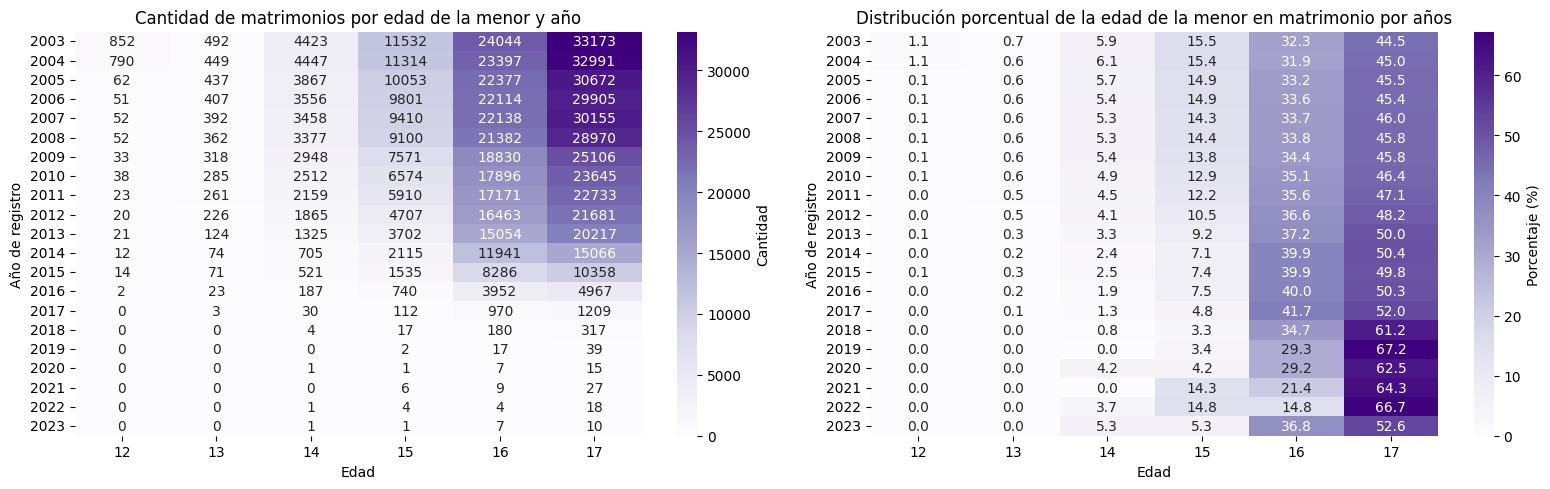

In [118]:
matrix = pd.crosstab(df['ANIO_REGIS'], df['EDAD_CON2'])
matrix_percentage = matrix.div(matrix.sum(axis=1), axis=0) * 100
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
sns.heatmap(matrix, annot=True, fmt="d", cmap="Purples", cbar_kws={'label': 'Cantidad'}, ax=axes[0])
axes[0].set_title('Cantidad de matrimonios por edad de la menor y año')
axes[0].set_xlabel('Edad')
axes[0].set_ylabel('Año de registro')
sns.heatmap(matrix_percentage, annot=True, fmt=".1f", cmap="Purples", cbar_kws={'label': 'Porcentaje (%)'}, ax=axes[1])
axes[1].set_title('Distribución porcentual de la edad de la menor en matrimonio por años')
axes[1].set_xlabel('Edad')
axes[1].set_ylabel('Año de registro')
plt.tight_layout()
plt.show()



<ipython-input-89-53bf86703e16>:21: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


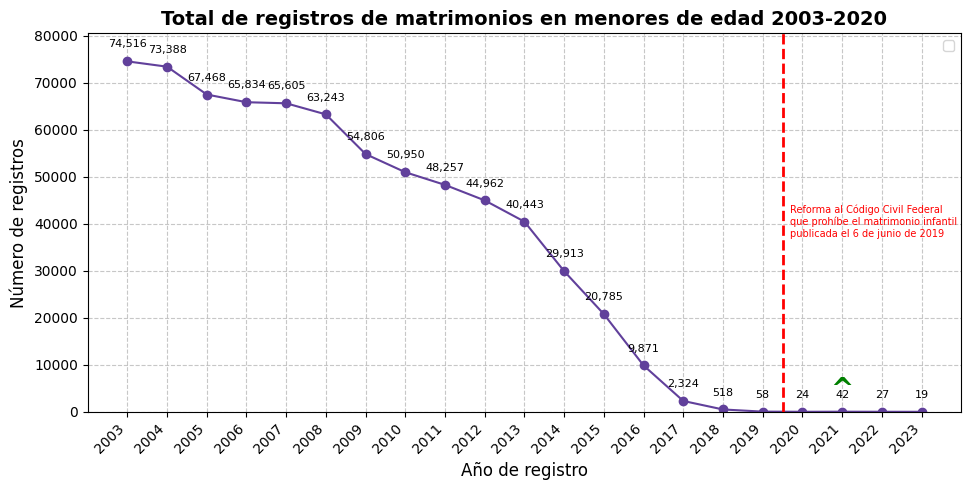

In [89]:
df["ANIO_REGIS"] = df["ANIO_REGIS"].astype(int)
tot_anio_regis = df.groupby("ANIO_REGIS").size().sort_index()
plt.figure(figsize=(10, 5))
y_max = max(tot_anio_regis.values) * 1.08
plt.ylim(0, y_max)
plt.plot(tot_anio_regis.index, tot_anio_regis.values, marker='o', linestyle='-',color=plt.cm.Purples(0.8))
plt.scatter(tot_anio_regis.index, tot_anio_regis.values, s=20, edgecolors='black')
plt.axvline(x=2019.5, color='red', linestyle='--', linewidth=2)
if 2021 in tot_anio_regis.index:
    plt.annotate('^',
                 xy=(2020.7, tot_anio_regis[2021]),
                 xytext=(2020.7, tot_anio_regis[2021] + 3000),
                 fontsize=20, fontweight='bold', color='green')
plt.text(2019.7, max(tot_anio_regis) * 0.5, "Reforma al Código Civil Federal \nque prohíbe el matrimonio infantil \npublicada el 6 de junio de 2019", color='red', fontsize=7)
for x, y in zip(tot_anio_regis.index, tot_anio_regis.values):
    plt.annotate(f'{y:,.0f}', (x, y), textcoords="offset points", xytext=(0, 10), ha='center', fontsize=8,)
plt.xticks(ticks=np.arange(tot_anio_regis.index.min(), tot_anio_regis.index.max() + 1, 1), rotation=45, ha='right')
plt.title('Total de registros de matrimonios en menores de edad 2003-2020', fontsize=14, fontweight='bold')
plt.xlabel('Año de registro', fontsize=12)
plt.ylabel('Número de registros', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


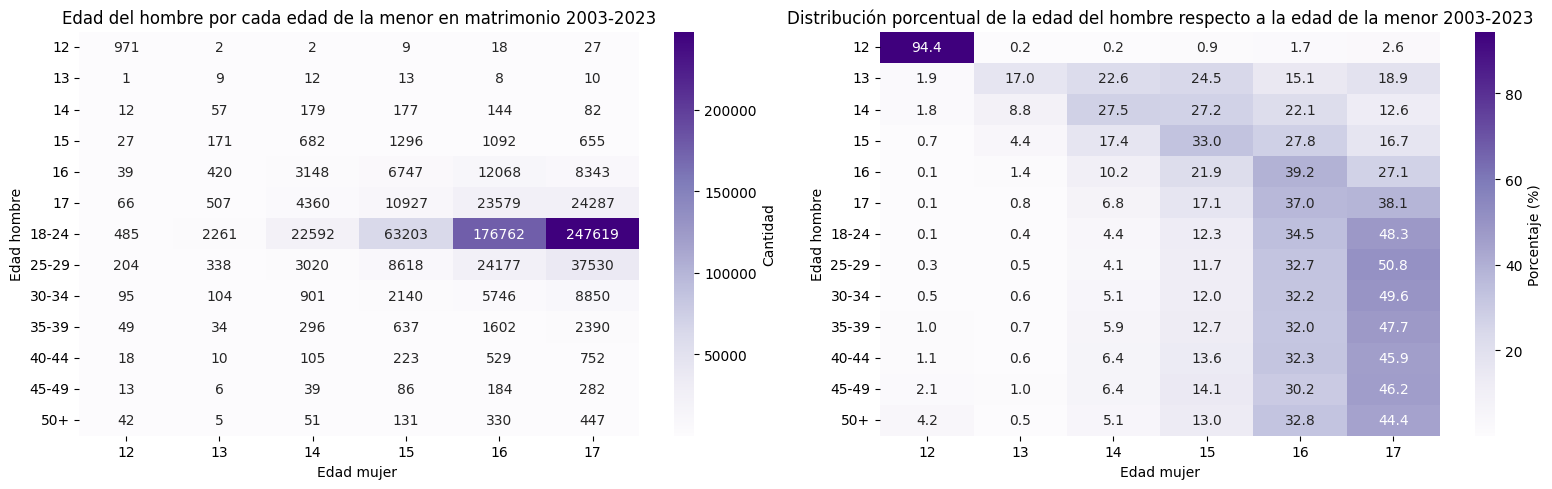

In [91]:
df["EDAD_CON1"] = df["EDAD_CON1"].astype(int)
def grupos_edad(age):
    if age > 17:
        if age >= 18 and age <= 24:
          return "18-24"
        elif age >= 25 and age <= 29:
          return "25-29"
        elif age >= 30 and age <= 34:
            return "30-34"
        elif age >= 35 and age <= 39:
            return "35-39"
        elif age >= 40 and age <= 44:
            return "40-44"
        elif age >= 45 and age <= 49:
            return "45-49"
        elif age >= 50:
          return "50+"
        else:
          return "Otro"
    else:
        return str(age)

df['GRUPO_EDAD'] = df['EDAD_CON1'].apply(grupos_edad)
GRUPO_EDAD = pd.crosstab(df['GRUPO_EDAD'], df['EDAD_CON2'])
GRUPO_EDAD_PERC = GRUPO_EDAD.div(GRUPO_EDAD.sum(axis=1), axis=0) * 100
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
sns.heatmap(GRUPO_EDAD, annot=True, fmt="d", cbar_kws={'label': 'Cantidad'}, ax=axes[0], cmap="Purples")
axes[0].set_title('Edad del hombre por cada edad de la menor en matrimonio 2003-2023')
axes[0].set_xlabel('Edad mujer ')
axes[0].set_ylabel('Edad hombre')
sns.heatmap(GRUPO_EDAD_PERC, annot=True, fmt=".1f", cmap="Purples", cbar_kws={'label': 'Porcentaje (%)'}, ax=axes[1])
axes[1].set_title('Distribución porcentual de la edad del hombre respecto a la edad de la menor 2003-2023')
axes[1].set_xlabel('Edad mujer')
axes[1].set_ylabel('Edad hombre')
plt.tight_layout()
plt.show()


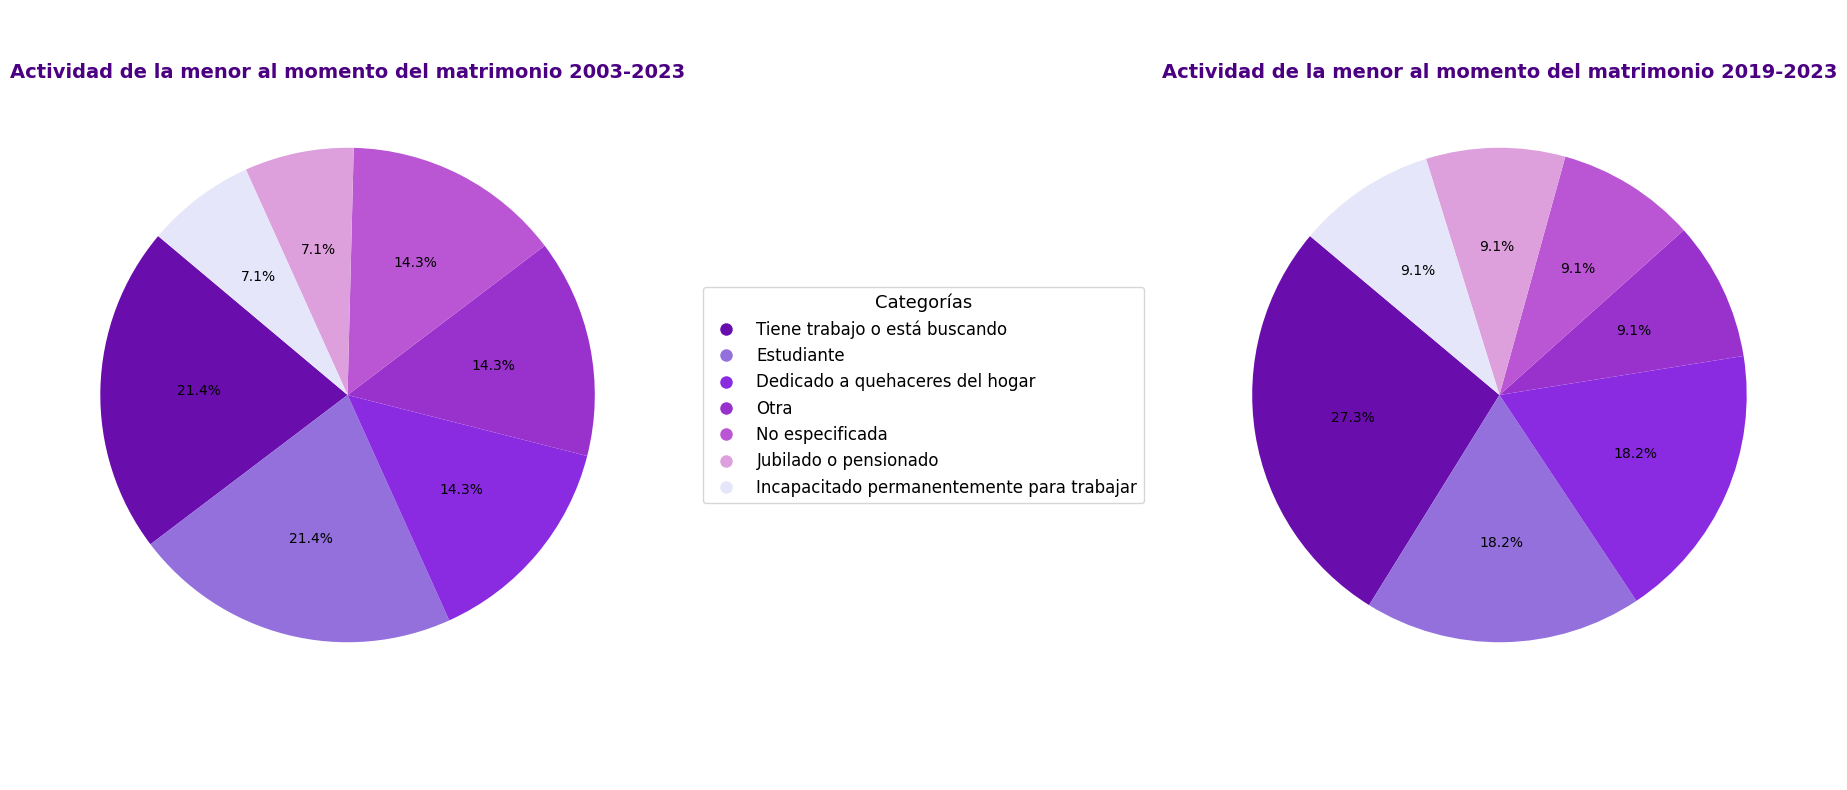

In [103]:
df['CONACTCON2'] = pd.to_numeric(df['CONACTCON2'], errors='coerce')
df['CONACTCON2_DESCRIPCION'] = df['CONACTCON2'].map(catalogo).fillna('Otra')
conactcon2_total = df['CONACTCON2_DESCRIPCION'].value_counts()
df_filtered = df[df['ANIO_REGIS'] > 18]
conactcon2_filtered = df_filtered['CONACTCON2_DESCRIPCION'].value_counts()
colors = ['#6a0dad', '#9370db', '#8a2be2', '#9932cc', '#ba55d3', '#dda0dd', '#e6e6fa']
fig, axes = plt.subplots(1, 3, figsize=(18, 8), gridspec_kw={'width_ratios': [1, 0.5, 1]})
axes[0].pie(
    conactcon2_total,
    labels=[''] * len(conactcon2_total),
    autopct='%1.1f%%',
    colors=colors[:len(conactcon2_total)],
    startangle=140
)
axes[0].set_title('Actividad de la menor al momento del matrimonio 2003-2023', fontsize=14, fontweight='bold', color='#4b0082')
axes[2].pie(
    conactcon2_filtered,
    labels=[''] * len(conactcon2_filtered),
    autopct='%1.1f%%',
    colors=colors[:len(conactcon2_filtered)],
    startangle=140
)
axes[2].set_title('Actividad de la menor al momento del matrimonio 2019-2023', fontsize=14, fontweight='bold', color='#4b0082')
axes[1].axis("off")
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[i], markersize=10)
                  for i in range(len(conactcon2_total))]
axes[1].legend(
    legend_handles,
    conactcon2_total.index,
    loc='center',
    fontsize=12,
    frameon=True,
    title="Categorías",
    title_fontsize=13
)
plt.tight_layout()
plt.show()



In [106]:
df = pd.read_csv('/content/drive/MyDrive/Matrimonios/MAT_INF_ADO.csv')

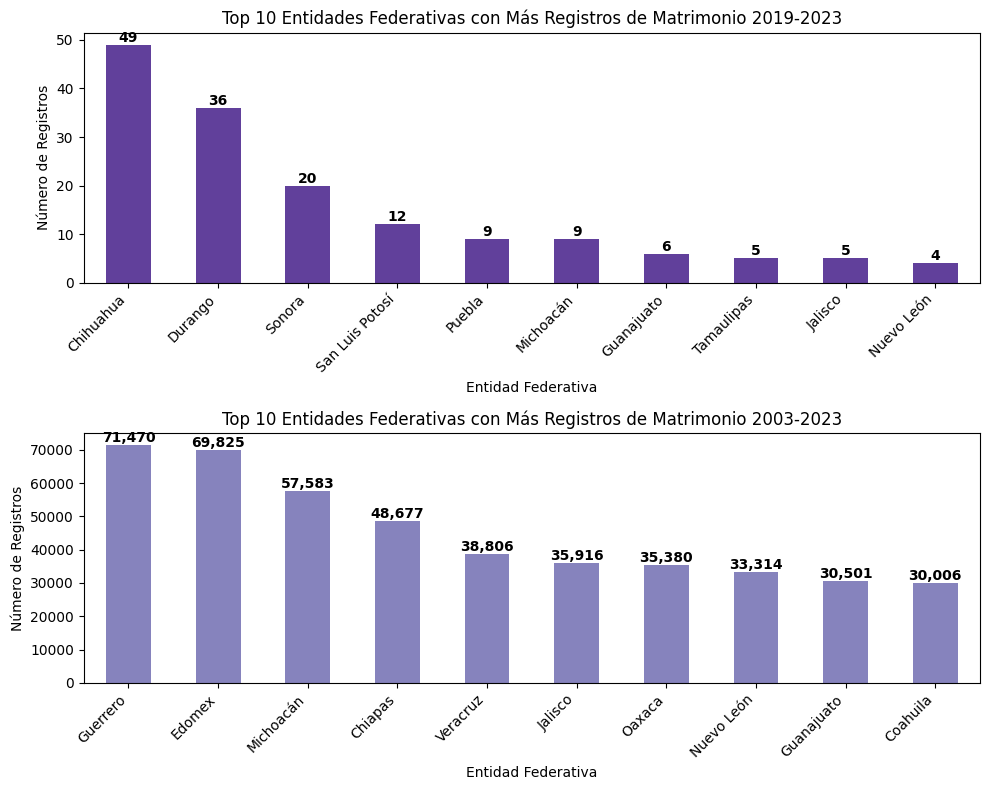

In [114]:
df["ENT_REGIS"] = df["ENT_REGIS"].astype(int)
entidades_dict = {
    5: "Coahuila", 12: "Guerrero", 15: "Edomex", 16: "Michoacán", 7: "Chiapas", 30: "Veracruz",
    14: "Jalisco", 20: "Oaxaca", 19: "Nuevo León", 11: "Guanajuato", 8: "Chihuahua",
    10: "Durango", 26: "Sonora", 24: "San Luis Potosí", 21: "Puebla", 28: "Tamaulipas",
}
df_filtered = df[df["ANIO_REGIS"] > 2018]
top_10_ent_regis = df.groupby("ENT_REGIS").size().sort_values(ascending=False).head(10)
top_10_ent_regis_19 = df_filtered.groupby("ENT_REGIS").size().sort_values(ascending=False).head(10)
top_10_ent_regis_19.index = top_10_ent_regis_19.index.map(lambda x: entidades_dict.get(x, x))
top_10_ent_regis.index = top_10_ent_regis.index.map(lambda x: entidades_dict.get(x, x))
fig, axes = plt.subplots(2, 1, figsize=(10, 8))
ax1 = top_10_ent_regis_19.plot(kind='bar', color=plt.cm.Purples(0.8), ax=axes[0])
for p in ax1.patches:
    ax1.annotate(f'{p.get_height():,.0f}', (p.get_x() + p.get_width() / 2, p.get_height()),
                 ha='center', va='bottom', fontsize=10, fontweight='bold', color='black')
ax1.set_title('Top 10 Entidades Federativas con Más Registros de Matrimonio 2019-2023')
ax1.set_xlabel('Entidad Federativa')
ax1.set_ylabel('Número de Registros')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')
ax2 = top_10_ent_regis.plot(kind='bar', color=plt.cm.Purples(0.6), ax=axes[1])
for p in ax2.patches:
    ax2.annotate(f'{p.get_height():,.0f}', (p.get_x() + p.get_width() / 2, p.get_height()),
                 ha='center', va='bottom', fontsize=10, fontweight='bold', color='black')
ax2.set_title('Top 10 Entidades Federativas con Más Registros de Matrimonio 2003-2023')
ax2.set_xlabel('Entidad Federativa')
ax2.set_ylabel('Número de Registros')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')
plt.tight_layout()
plt.show()
